Memory growth enabled
Mixed precision policy: <Policy "mixed_float16">
Loaded 799 images for training.

Epoch 1/200
Step 0: Gen Loss: 25.1250, Disc Loss: 0.8008
Step 50: Gen Loss: 15.8281, Disc Loss: 0.4419

Epoch 2/200
Step 0: Gen Loss: 13.3359, Disc Loss: 0.2654
Step 50: Gen Loss: 14.8594, Disc Loss: 0.1436

Epoch 3/200
Step 0: Gen Loss: 15.1016, Disc Loss: 0.3953
Step 50: Gen Loss: 11.6172, Disc Loss: 0.2871

Epoch 4/200
Step 0: Gen Loss: 12.3203, Disc Loss: 0.4136
Step 50: Gen Loss: 9.9531, Disc Loss: 0.8633

Epoch 5/200
Step 0: Gen Loss: 11.0391, Disc Loss: 0.3208
Step 50: Gen Loss: 9.0156, Disc Loss: 0.8516

Epoch 6/200
Step 0: Gen Loss: 11.5234, Disc Loss: 0.9287
Step 50: Gen Loss: 10.4922, Disc Loss: 0.3264

Epoch 7/200
Step 0: Gen Loss: 8.4219, Disc Loss: 0.8647
Step 50: Gen Loss: 9.0234, Disc Loss: 0.5713

Epoch 8/200
Step 0: Gen Loss: 9.9453, Disc Loss: 0.6035
Step 50: Gen Loss: 7.9219, Disc Loss: 0.6104

Epoch 9/200
Step 0: Gen Loss: 9.4688, Disc Loss: 0.3164
Step 50: Gen L

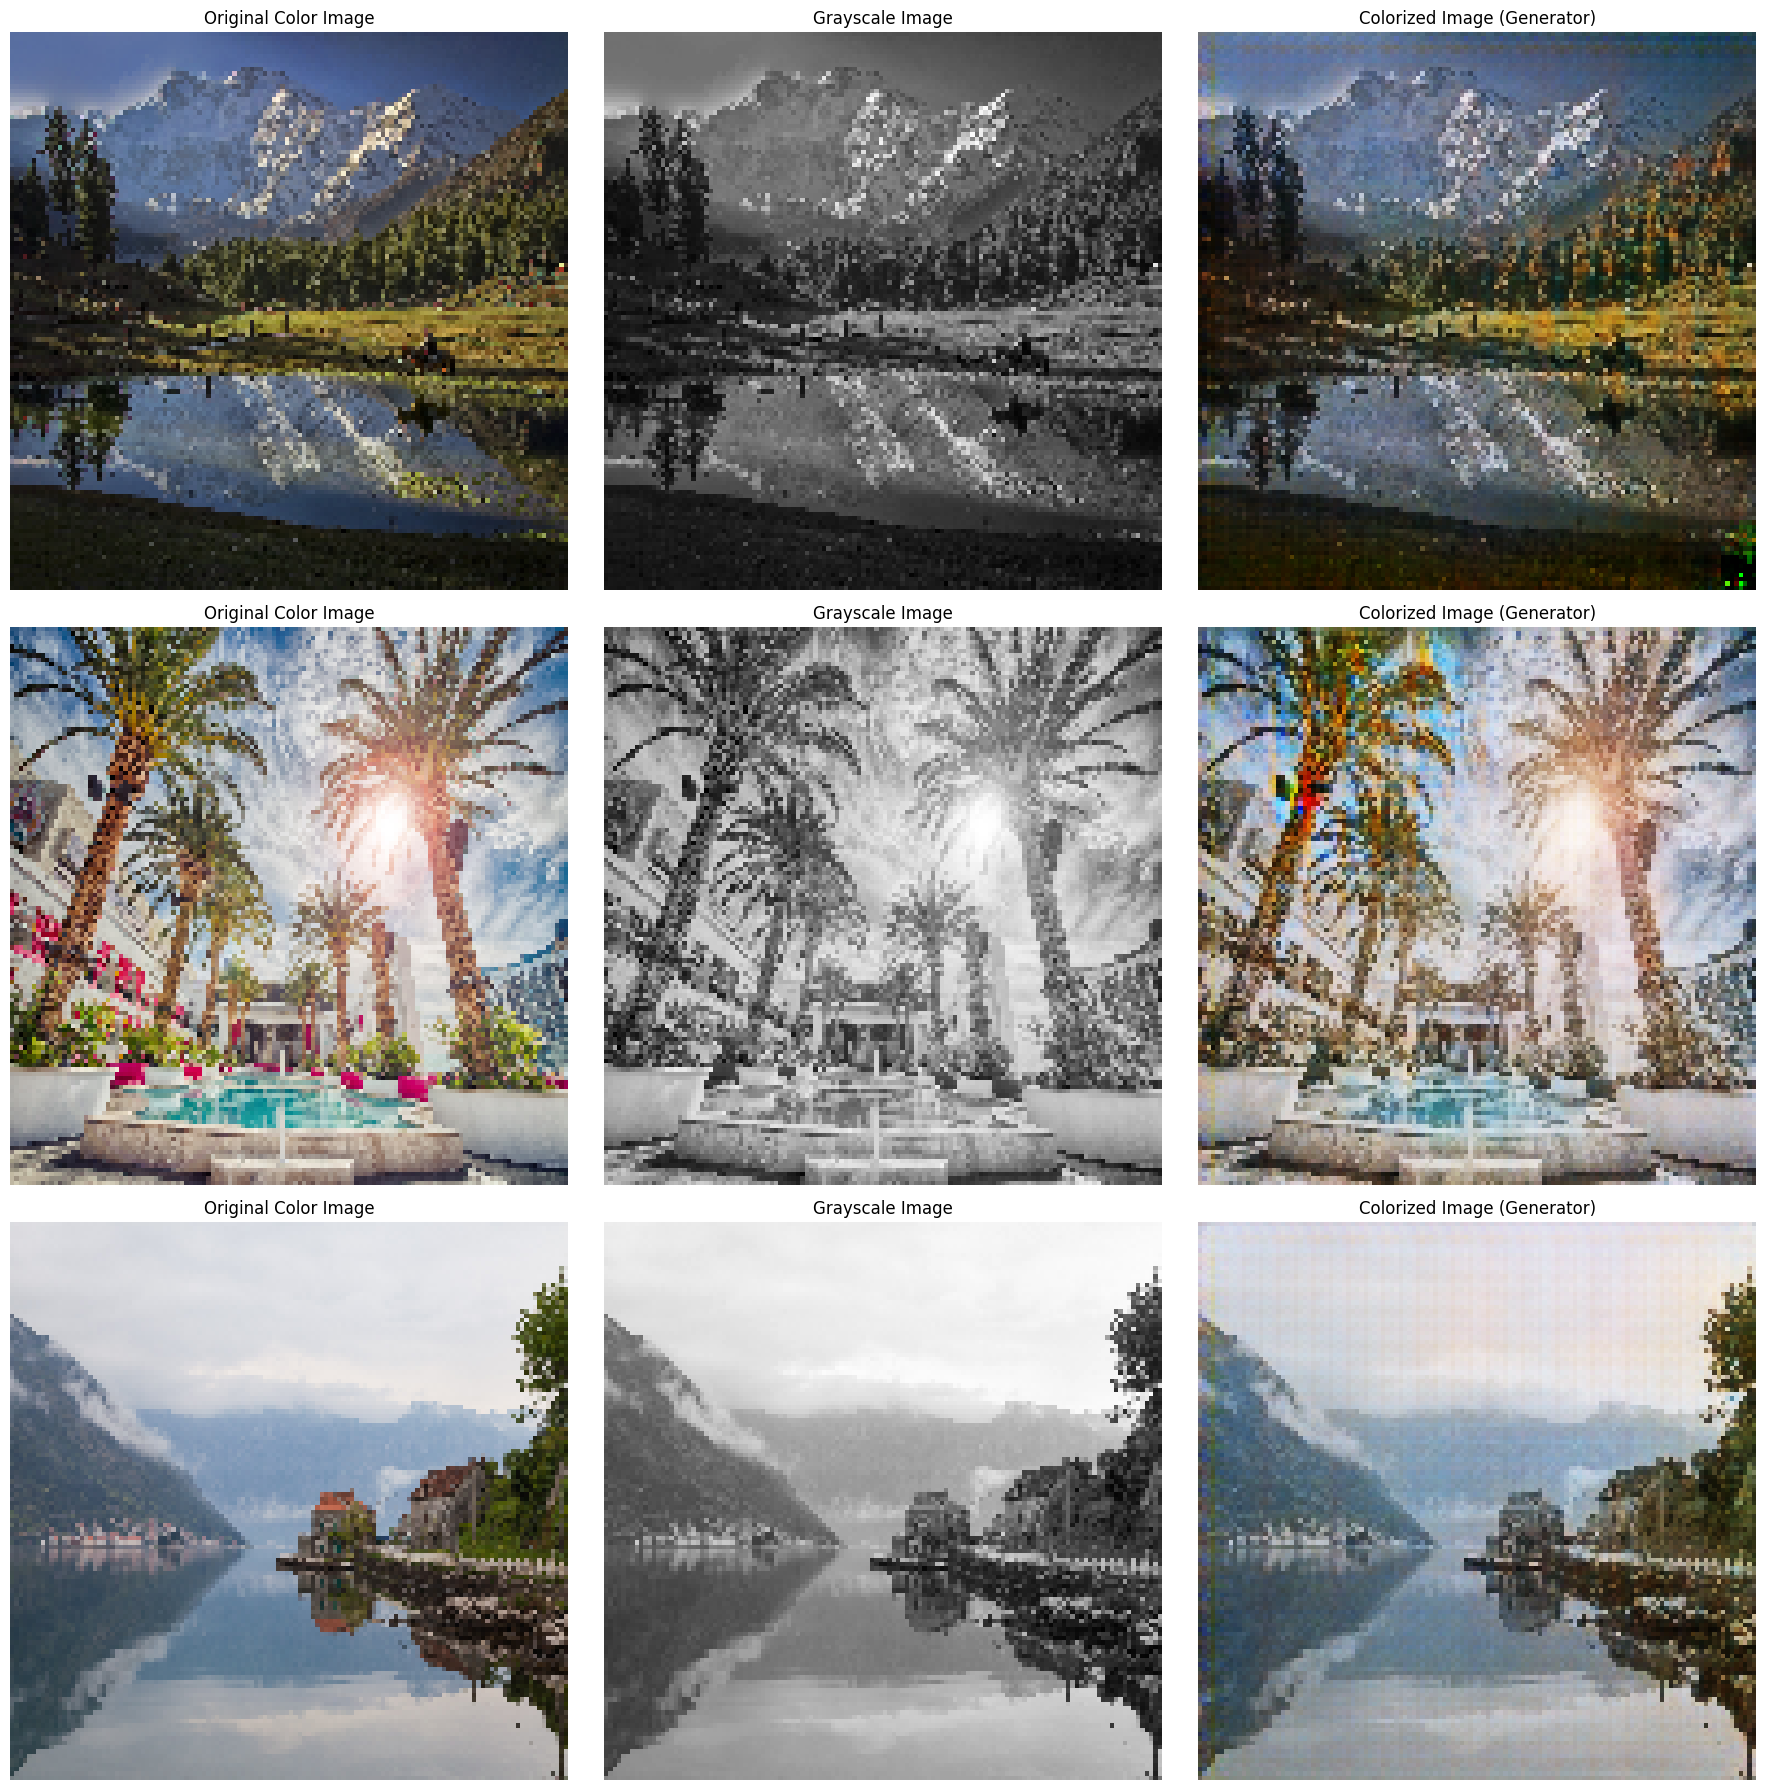


Epoch 101/200
Step 0: Gen Loss: 9.6953, Disc Loss: 0.0128
Step 50: Gen Loss: 10.3516, Disc Loss: 0.0050

Epoch 102/200
Step 0: Gen Loss: 11.3125, Disc Loss: 0.0031
Step 50: Gen Loss: 9.6250, Disc Loss: 0.0064

Epoch 103/200
Step 0: Gen Loss: 5.4883, Disc Loss: 0.6787
Step 50: Gen Loss: 4.8359, Disc Loss: 0.6680

Epoch 104/200
Step 0: Gen Loss: 4.5273, Disc Loss: 0.6709
Step 50: Gen Loss: 4.8203, Disc Loss: 0.6680

Epoch 105/200
Step 0: Gen Loss: 4.7812, Disc Loss: 0.7451
Step 50: Gen Loss: 4.2617, Disc Loss: 0.6860

Epoch 106/200
Step 0: Gen Loss: 5.9609, Disc Loss: 0.7539
Step 50: Gen Loss: 5.9922, Disc Loss: 0.5327

Epoch 107/200
Step 0: Gen Loss: 4.3281, Disc Loss: 0.7183
Step 50: Gen Loss: 5.4180, Disc Loss: 0.6177

Epoch 108/200
Step 0: Gen Loss: 5.4609, Disc Loss: 0.5239
Step 50: Gen Loss: 6.9609, Disc Loss: 0.4983

Epoch 109/200
Step 0: Gen Loss: 5.7773, Disc Loss: 0.5688
Step 50: Gen Loss: 4.4219, Disc Loss: 0.7627

Epoch 110/200
Step 0: Gen Loss: 6.4219, Disc Loss: 0.6416
Ste

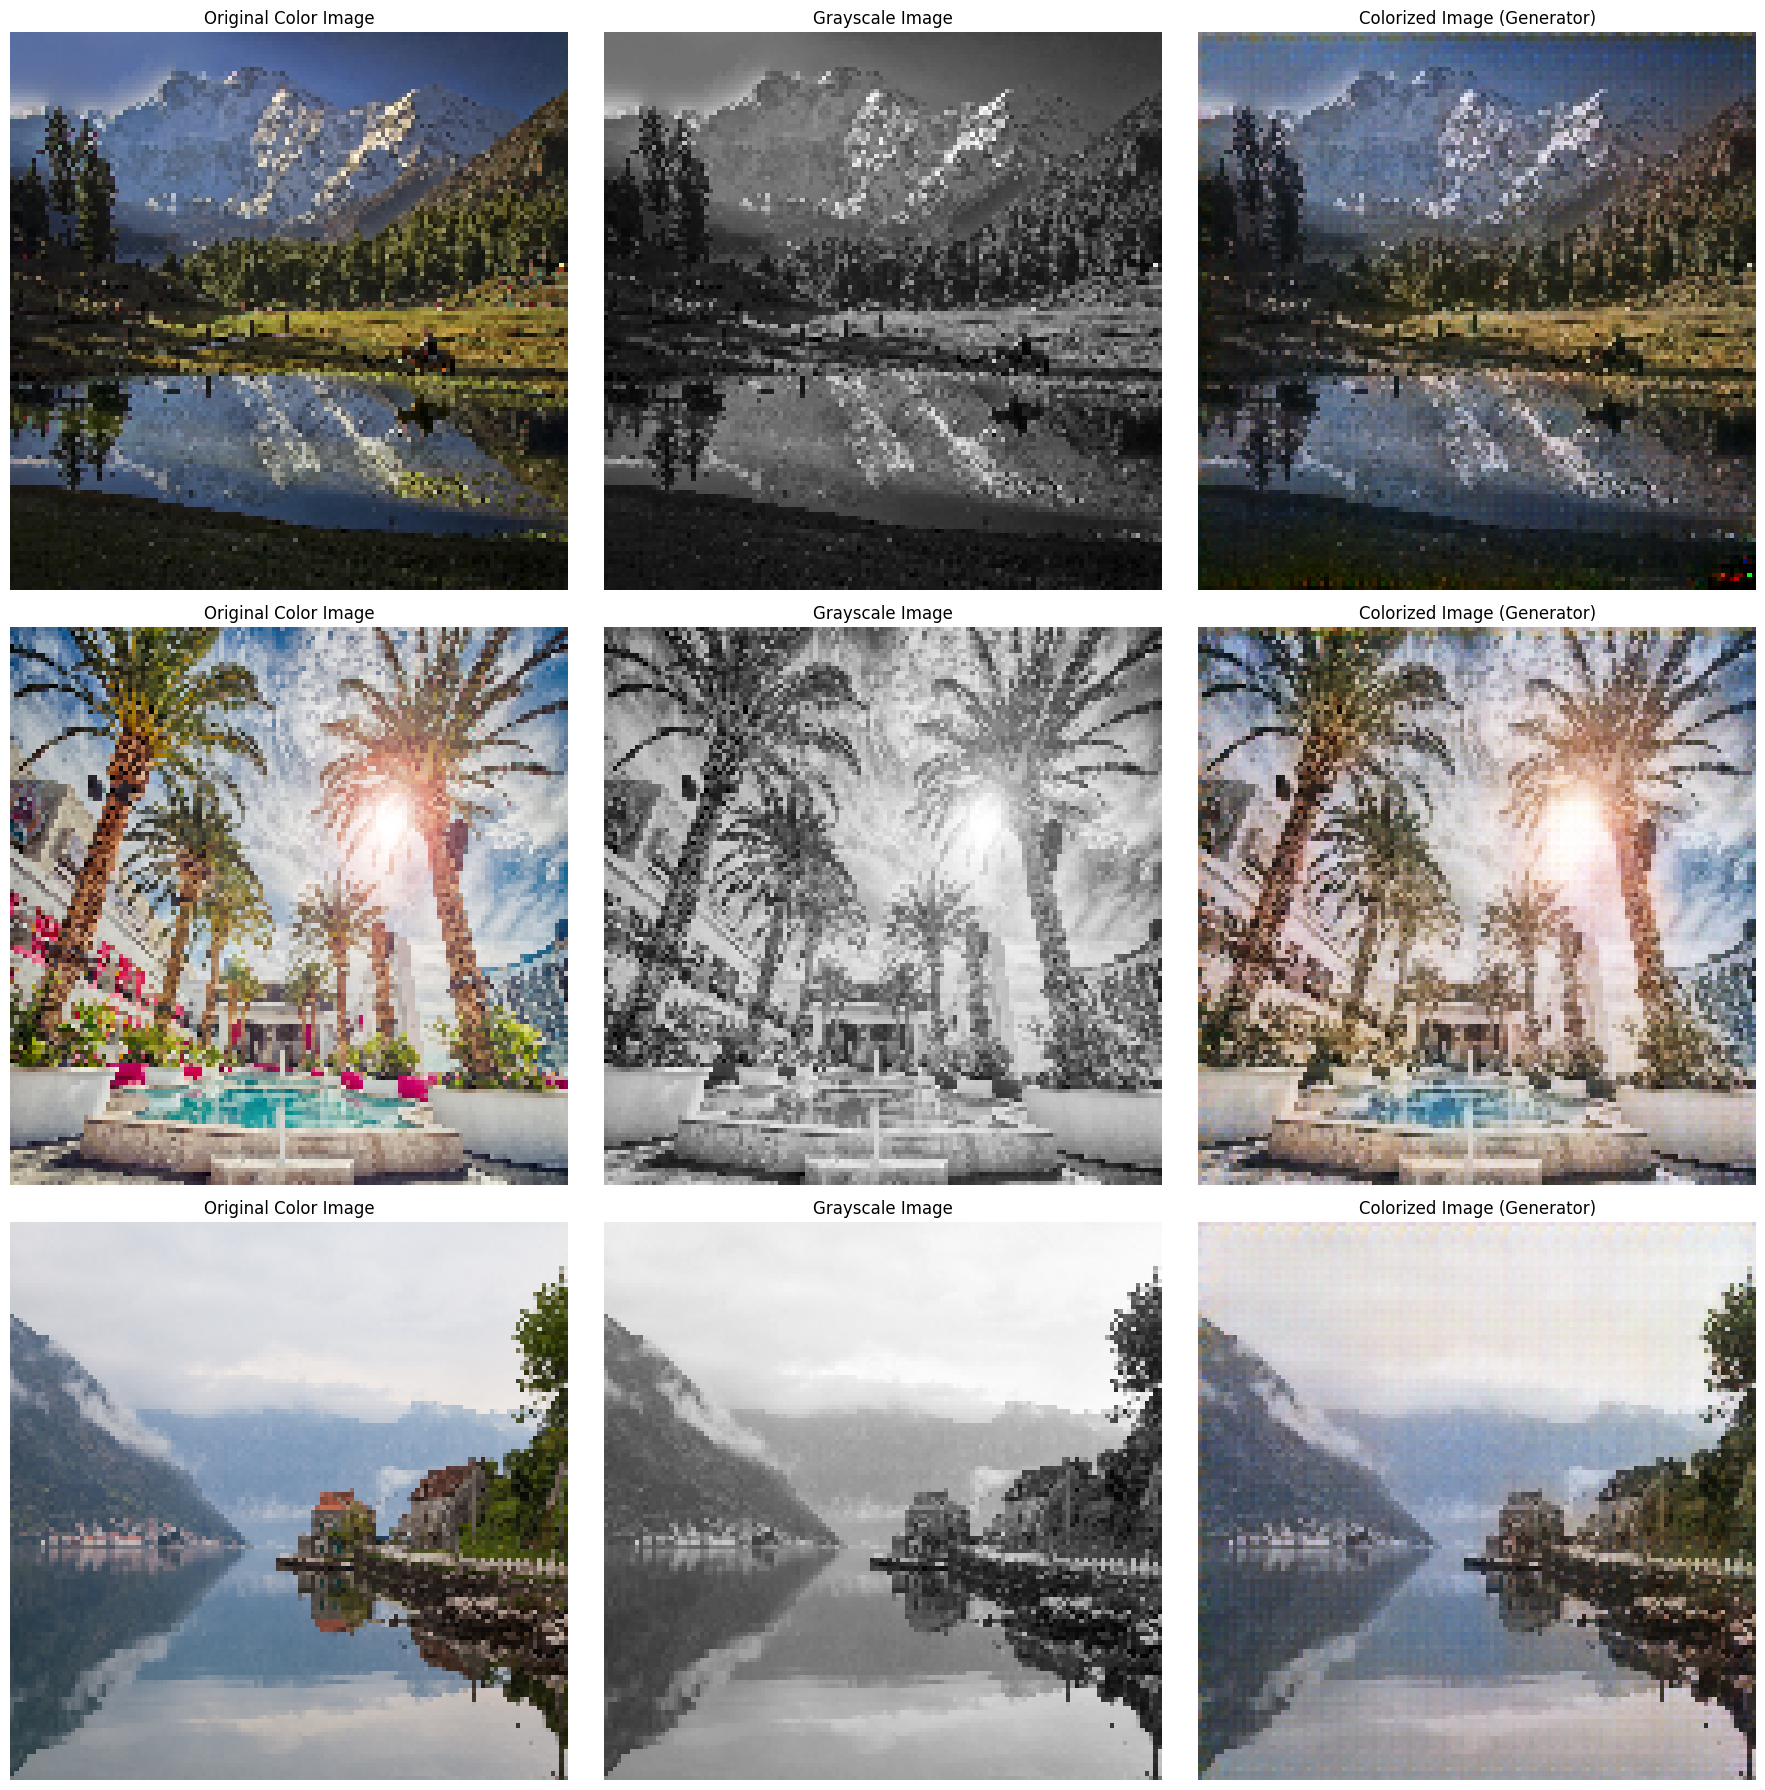

Model saved to output/colorization_generator_cgan.h5.


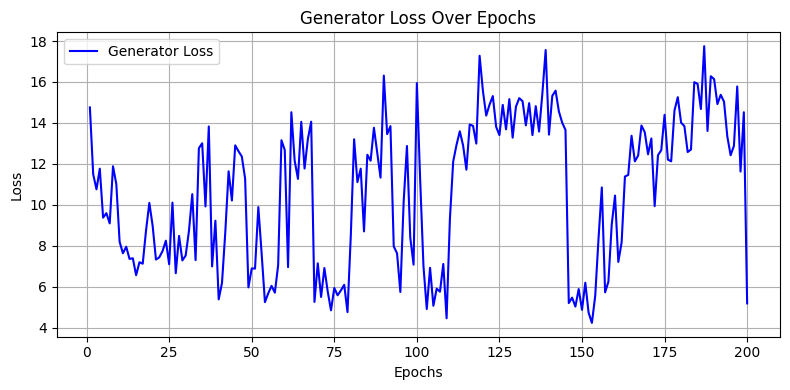

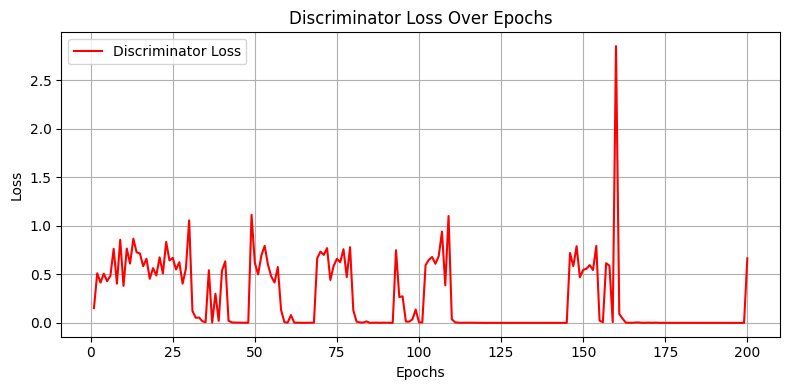

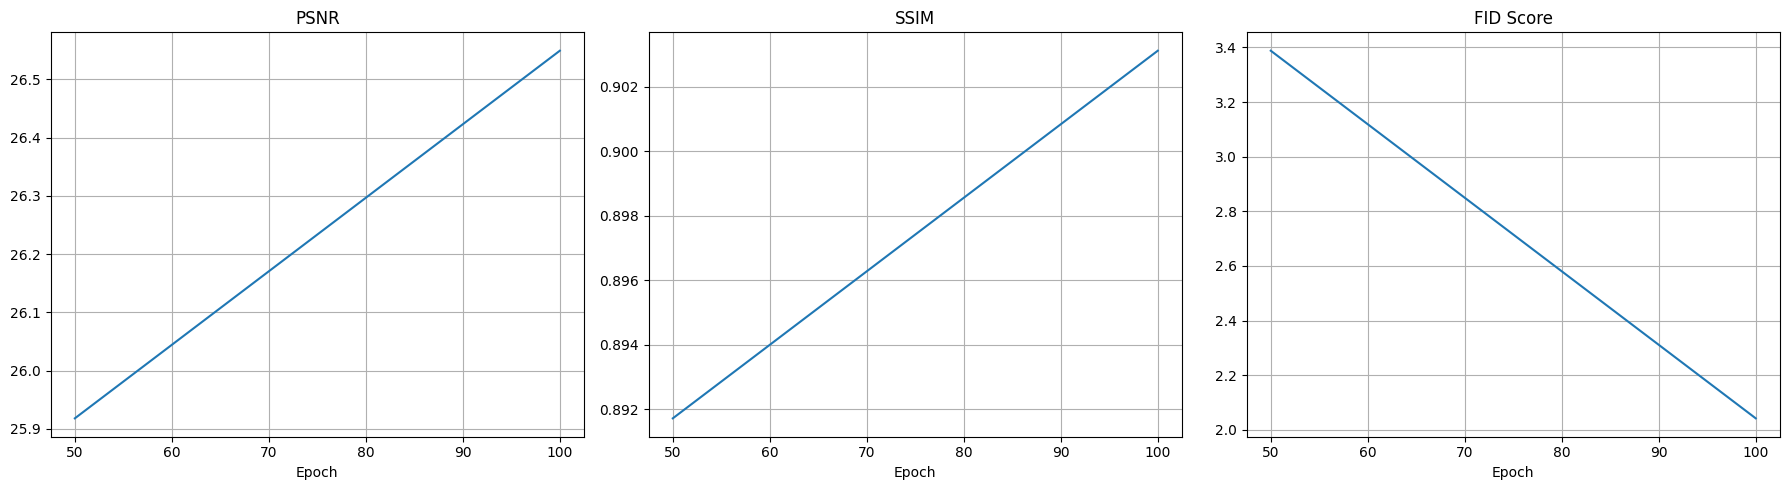

In [16]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, Conv2DTranspose, LeakyReLU, Activation, Concatenate, BatchNormalization)
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Enable dynamic GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled")
    except RuntimeError as e:
        print(e)

# Enable mixed precision training to reduce memory usage
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print("Mixed precision policy:", policy)

# --------------------
# Data Preparation
# --------------------
def load_data(image_dir, image_size=(128, 128)):
    color_images = []
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    for file in image_files:
        img_path = os.path.join(image_dir, file)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, image_size)
        color_images.append(img)
    
    color_images = np.array(color_images, dtype="float32") / 255.0
    
    grayscale_images = []
    for img in color_images:
        gray = cv2.cvtColor((img * 255).astype("uint8"), cv2.COLOR_RGB2GRAY)
        gray = gray.astype("float32") / 255.0
        grayscale_images.append(gray)
    
    grayscale_images = np.array(grayscale_images)[..., np.newaxis]
    return grayscale_images, color_images

# --------------------
# Generator Model
# --------------------
def build_generator(input_shape=(128, 128, 1)):
    inputs = Input(shape=input_shape)
    def conv_block(x, filters, kernel_size=3, bn=True):
        x = Conv2D(filters, kernel_size, strides=2, padding='same')(x)
        if bn:
            x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        return x
    def deconv_block(x, skip, filters, kernel_size=3, dropout_rate=0):
        x = Conv2DTranspose(filters, kernel_size, strides=2, padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        if dropout_rate:
            x = tf.keras.layers.Dropout(dropout_rate)(x)
        x = Concatenate()([x, skip])
        return x
    e1 = conv_block(inputs, 64, bn=False)
    e2 = conv_block(e1, 128)
    e3 = conv_block(e2, 256)
    e4 = conv_block(e3, 512)
    e5 = conv_block(e4, 512)
    b = Conv2D(512, 3, padding='same', activation='relu')(e5)
    d1 = deconv_block(b, e4, 512, dropout_rate=0.5)
    d2 = deconv_block(d1, e3, 256, dropout_rate=0.5)
    d3 = deconv_block(d2, e2, 128)
    d4 = deconv_block(d3, e1, 64)
    d5 = Conv2DTranspose(3, 3, strides=2, padding='same', activation='sigmoid', dtype='float32')(d4)
    return Model(inputs, d5)

# --------------------
# Discriminator
# --------------------
def build_discriminator(input_shape_gray=(128, 128, 1), input_shape_color=(128, 128, 3)):
    input_gray = Input(shape=input_shape_gray)
    input_color = Input(shape=input_shape_color)
    combined_input = Concatenate()([input_gray, input_color])
    def disc_block(x, filters, kernel_size=4, strides=2, bn=True):
        x = Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
        if bn:
            x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        return x
    d1 = disc_block(combined_input, 64, bn=False)
    d2 = disc_block(d1, 128)
    d3 = disc_block(d2, 256)
    d4 = disc_block(d3, 512)
    patch_out = Conv2D(1, 4, padding='same')(d4)
    patch_out = Activation('sigmoid')(patch_out)
    return Model([input_gray, input_color], patch_out)

# --------------------
# Loss Functions & Optimizers
# --------------------
bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
def l1_loss(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
LAMBDA = 100

# --------------------
# Build Models
# --------------------
generator = build_generator(input_shape=(128, 128, 1))
discriminator = build_discriminator(input_shape_gray=(128, 128, 1), input_shape_color=(128, 128, 3))

# --------------------
# Training Step
# --------------------
@tf.function
def train_step(grayscale, color):
    batch_size = tf.shape(grayscale)[0]
    real_labels = tf.ones((batch_size, 8, 8, 1))
    fake_labels = tf.zeros((batch_size, 8, 8, 1))
    with tf.GradientTape(persistent=True) as tape:
        fake_color = generator(grayscale, training=True)
        disc_real = discriminator([grayscale, color], training=True)
        disc_fake = discriminator([grayscale, fake_color], training=True)
        d_loss_real = bce_loss(real_labels, disc_real)
        d_loss_fake = bce_loss(fake_labels, disc_fake)
        disc_loss = 0.5 * (d_loss_real + d_loss_fake)
        gen_adv_loss = bce_loss(real_labels, disc_fake)
        gen_l1 = l1_loss(color, fake_color)
        lambda_tensor = tf.cast(LAMBDA, gen_adv_loss.dtype)
        gen_l1 = tf.cast(gen_l1, gen_adv_loss.dtype)
        gen_loss = gen_adv_loss + lambda_tensor * gen_l1
    gradients_gen = tape.gradient(gen_loss, generator.trainable_variables)
    gradients_disc = tape.gradient(disc_loss, discriminator.trainable_variables)
    gen_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))
    return gen_loss, disc_loss

# --------------------
# Visualization
# --------------------
def display_results(original_imgs, gray_imgs, colorized_imgs):
    n = len(original_imgs)
    fig, axs = plt.subplots(n, 3, figsize=(18, 6 * n))
    if n == 1:
        axs = np.expand_dims(axs, axis=0)
    for i in range(n):
        axs[i, 0].imshow(original_imgs[i])
        axs[i, 0].set_title("Original Color Image")
        axs[i, 0].axis("off")
        axs[i, 1].imshow(gray_imgs[i].squeeze(), cmap="gray")
        axs[i, 1].set_title("Grayscale Image")
        axs[i, 1].axis("off")
        axs[i, 2].imshow(colorized_imgs[i])
        axs[i, 2].set_title("Colorized Image (Generator)")
        axs[i, 2].axis("off")
    plt.tight_layout()
    plt.show()

# --------------------
# Training Loop with Metrics
# --------------------
def train_gan(image_dir, epochs=100, batch_size=2, image_size=(128, 128)):
    from skimage.metrics import peak_signal_noise_ratio as psnr
    from skimage.metrics import structural_similarity as ssim
    from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
    from scipy.linalg import sqrtm

    def calculate_fid(real_images, generated_images):
        model = InceptionV3(include_top=False, pooling='avg', input_shape=(128, 128, 3))
        real_images = preprocess_input(real_images.astype('float32'))
        gen_images = preprocess_input(generated_images.astype('float32'))
        act1 = model.predict(real_images, verbose=0)
        act2 = model.predict(gen_images, verbose=0)
        mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
        mu2 = act2.mean(axis=0)
        sigma2 = np.cov(act2, rowvar=False)
        ssdiff = np.sum((mu1 - mu2) ** 2.0)
        covmean = sqrtm(sigma1.dot(sigma2))
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
        return fid

    grayscale_images, color_images = load_data(image_dir, image_size=image_size)
    print(f"Loaded {grayscale_images.shape[0]} images for training.")
    dataset = tf.data.Dataset.from_tensor_slices((grayscale_images, color_images)).shuffle(1024).batch(batch_size)

    sample_gray = grayscale_images[:3]
    sample_color = color_images[:3]

    gen_losses, disc_losses = [], []
    psnr_scores, ssim_scores, fid_scores = [], [], []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        for step, (gray_batch, color_batch) in enumerate(dataset):
            g_loss, d_loss = train_step(gray_batch, color_batch)
            if step % 50 == 0:
                print(f"Step {step}: Gen Loss: {g_loss.numpy():.4f}, Disc Loss: {d_loss.numpy():.4f}")
        gen_losses.append(g_loss.numpy())
        disc_losses.append(d_loss.numpy())

        if (epoch + 1) % 100 == 0:
            fake_color = generator(sample_gray, training=False).numpy()
            real_images = np.clip(sample_color, 0.0, 1.0)
            generated_images = np.clip(fake_color, 0.0, 1.0)

            psnr_val = np.mean([psnr(real_images[i], generated_images[i]) for i in range(len(real_images))])
            ssim_val = np.mean([ssim(real_images[i], generated_images[i], channel_axis=-1, data_range=1.0) for i in range(len(real_images))])
            fid_val = calculate_fid(real_images, generated_images)

            psnr_scores.append(psnr_val)
            ssim_scores.append(ssim_val)
            fid_scores.append(fid_val)

            print(f"Metrics @ Epoch {epoch+1}: PSNR={psnr_val:.2f}, SSIM={ssim_val:.4f}, FID={fid_val:.2f}")

            fake_color_disp = [(img * 255).astype("uint8") for img in fake_color]
            original_disp = [(img * 255).astype("uint8") for img in sample_color]
            sample_gray_disp = [((img.squeeze()) * 255).astype("uint8") for img in sample_gray]
            display_results(original_disp, sample_gray_disp, fake_color_disp)

    # Save the generator
    output_folder = os.path.join(os.getcwd(), "output")
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    generator.save(os.path.join(output_folder, "colorization_generator_cgan.h5"))
    print("Model saved to output/colorization_generator_cgan.h5.")

    # Plot Generator Loss
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(gen_losses) + 1), gen_losses, label='Generator Loss', color='blue')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Generator Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot Discriminator Loss
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(disc_losses) + 1), disc_losses, label='Discriminator Loss', color='red')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Discriminator Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot PSNR, SSIM, FID
    plt.figure(figsize=(18, 5))
    epochs_metric = list(range(50, 50 * len(psnr_scores) + 1, 50))

    plt.subplot(1, 3, 1)
    plt.plot(epochs_metric, psnr_scores, label="PSNR")
    plt.title("PSNR")
    plt.xlabel("Epoch")
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(epochs_metric, ssim_scores, label="SSIM")
    plt.title("SSIM")
    plt.xlabel("Epoch")
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(epochs_metric, fid_scores, label="FID")
    plt.title("FID Score")
    plt.xlabel("Epoch")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# --------------------
# Main
# --------------------
if __name__ == "__main__":
    train_folder = os.path.join(os.getcwd(), "div2k_dataset", "DIV2K_train_HR", "DIV2K_train_HR")
    if not os.path.exists(train_folder):
        raise FileNotFoundError("Train folder not found. Please check your local 'div2k_dataset' folder structure.")
    train_gan(train_folder, epochs=200, batch_size=10, image_size=(128, 128))
